# Selecting intracellular ions and creating a new METASPACE annotation database
This notebook shows how to select intracellular metabolites from processed SpaceM data.
Ion-cell colocalization is quantified using either Spearman correlation or an area-**n**ormalized **M**anders **C**olocalization **C**oefficient (NMCC).  
Selected ions can be used to create a custom annotation database for use on METASPACE.

<div class="alert alert-info"> 

You can also download this notebook [here](https://git.embl.de/mattausc/outer-spacem/-/raw/master/docs/examples/intracell_selection/create_database.ipynb?inline=false) or as part of our [collection of SpaceM analysis notebooks](https://git.embl.de/grp-alexandrov/spacem-analysis-notebooks).

</div>

Before running this notebook, make sure to...  

- [Install the METASPACE Python client](https://pypi.org/project/metaspace2020/)  
- [Create an API key for METASPACE](https://metaspace2020.eu/user/me)
- [Register your API key locally](https://metaspace2020.readthedocs.io/en/latest/content/examples/fetch-dataset-annotations.html#Connect-to-the-sm-server)  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from pathlib import Path

from scipy.stats import spearmanr

from metaspace import SMInstance

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

In [2]:
sns.set(
    rc={
        "figure.figsize":(7.5,7.5), 
        "legend.frameon": False
    },
    style="ticks",
    context="notebook"
)

### Setup

Quantification of ion-cell localization is done on the spatiomolecular matrices of **ablation marks** that are produced (i.e. the matrices stored in the `analysis/ablation_mark_analysis` directory, from here on called **AM matrix**).
For this example we're going to use the AM matrices of three SpaceM datasets.

From experience it makes close to no difference for ion selection whether ion-cell colocalization is evaluated on the combined datasets together, or separately and then aggregated. This notebook computes the scores separately and then aggregates them, so there is no need to concatenate all your dataseset before running them through this notebook.

<div class="alert alert-info">

**Note:** For this notebook you're going to need the AM matrices' .csv files, not the .h5ad ones!

</div>

In [3]:
# Datasets to be used to select intracellular ions

dataset_paths = [
    # "/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/scratch/projects/gastrosome_processing/SpaceM_processing_new/Drug_W8/analysis/ablation_mark_analysis/spatiomolecular_matrix.csv",
    "/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/scratch/projects/gastrosome_processing/SpaceM_processing_new/Feeding_W3/analysis/ablation_mark_analysis/spatiomolecular_matrix.csv"
]

#### Which selection method should I use?
- Use `'nmcc'` if you only need high precision for cells (i.e. ions should be exclusive to cells but do not need to be present in all cells in a dataset)
- Use `'spearman'` if you want your ions to have high precision *and* recall for cells (i.e. ions should be exclusive to cells and also present in all cells)

An ion's NMCC is defined as  
\begin{equation}
\frac{\text{on-sample ion counts}}{\text{on-sample ion counts + off-sample counts}} \cdot \frac{\text{off-sample area}}{\text{on-sample area}}
\end{equation}
Or, more precisely:
\begin{equation}
M = \frac{\sum_i I_i \cdot f_i}{\sum_i I_i \cdot f_i + \sum_i I_i \cdot (1-f_i)\cdot \frac{\overline{f}}{1 - \overline{f}}}
\end{equation}

Where $I_i$ is the ion's intensity and $f_i$ is ablation mark sampling ratio for pixel $i$.  
Essentially it describes the fraction of ions that are on-sample when off- and on-sample areas are the same size.  
An NMCC of 0 therefore indicates that all ions are off-sample (i.e. exclusively extracellular), 0.5 indicates that ions are evenly distributed between on- and off-sample area, and 1 indicates that all ions are exclusively on-sample (i.e. intracellular).

#### Filtering out low-abundance ions
Low occurence ions have shown to have very little contribution to overall variance in SpaceM datasets and have close to zero impact on clusterings.  
Unless you specifically want to analyse these low-occurence ions, you can exclude them here from your database using the `nonzero_thresold` parameter. By default, only ions that are present in >2.5% of pixels in at least one dataset are included.
If you don't want to exclude low-abundance ions, set this parameter to 0.

In [4]:
selection_method = "nmcc" # "nmcc" or "spearman"
selection_threshold = 0.6
# Recommended for spearman: 0.1-0.2
# Recommended for nmcc: 0.6-0.7

nonzero_threshold = 0. # 0.025 # Only include ions present in > 2.5% of pixels in >= 1 dataset(s). Set to 0 to disable.

### Evaluate & select intracellular ions

In [5]:
def nmcc(I, f):
    f_ = f.mean()
    I_on = np.sum(I * f)
    I_off = np.sum(I * (1 - f) * (f_ / (1 - f_)))
    return I_on / (I_on + I_off)

##### Load the datasets

In [6]:
am_matrices = []

ion_regex = r"^C[0-9]*.*?[\+-]" # This excludes SpaceM's image analysis features. You might want to adjust this if you want to include non-carbon metabolites!

for ds_idx, ds_path in enumerate(dataset_paths):
    print(ds_idx, ds_path)
    amm = pd.read_csv(ds_path)
    amm["dataset"] = ds_idx
    am_matrices.append(amm)

am_matrix = pd.concat(am_matrices, ignore_index=True).fillna(0)
ions = am_matrix.columns.to_series().filter(regex=ion_regex).values

print(f"Read {len(am_matrices)} datasets containing {len(ions)} unique ion annotations for {len(am_matrix)} pixels.")

0 /Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/scratch/projects/gastrosome_processing/SpaceM_processing_new/Feeding_W3/analysis/ablation_mark_analysis/spatiomolecular_matrix.csv
Read 1 datasets containing 820 unique ion annotations for 22500 pixels.


In [7]:
scores = pd.DataFrame()

for dataset, ds_amm in am_matrix.groupby(["dataset"]):
    for ion in ions:
        if (ds_amm[ion] != 0).mean() > nonzero_threshold:
            ion_scores = {
                "dataset": dataset,
                "ion": ion,
                "spearman": spearmanr(ds_amm[ion], ds_amm["am_sampling_ratio"]).correlation,
                "nmcc": nmcc(ds_amm[ion], ds_amm["am_sampling_ratio"])
            }
            scores = pd.concat([scores, pd.DataFrame(ion_scores, index=[0])], ignore_index=True)
            
scores_agg = scores.groupby(["ion"])[["spearman", "nmcc"]].mean()
scores_agg["selected"] = scores_agg[selection_method] > selection_threshold

Once we have computed the scores, we can take a closer look at the distribution of per-ion scores for both spearman correlation and NMCC:

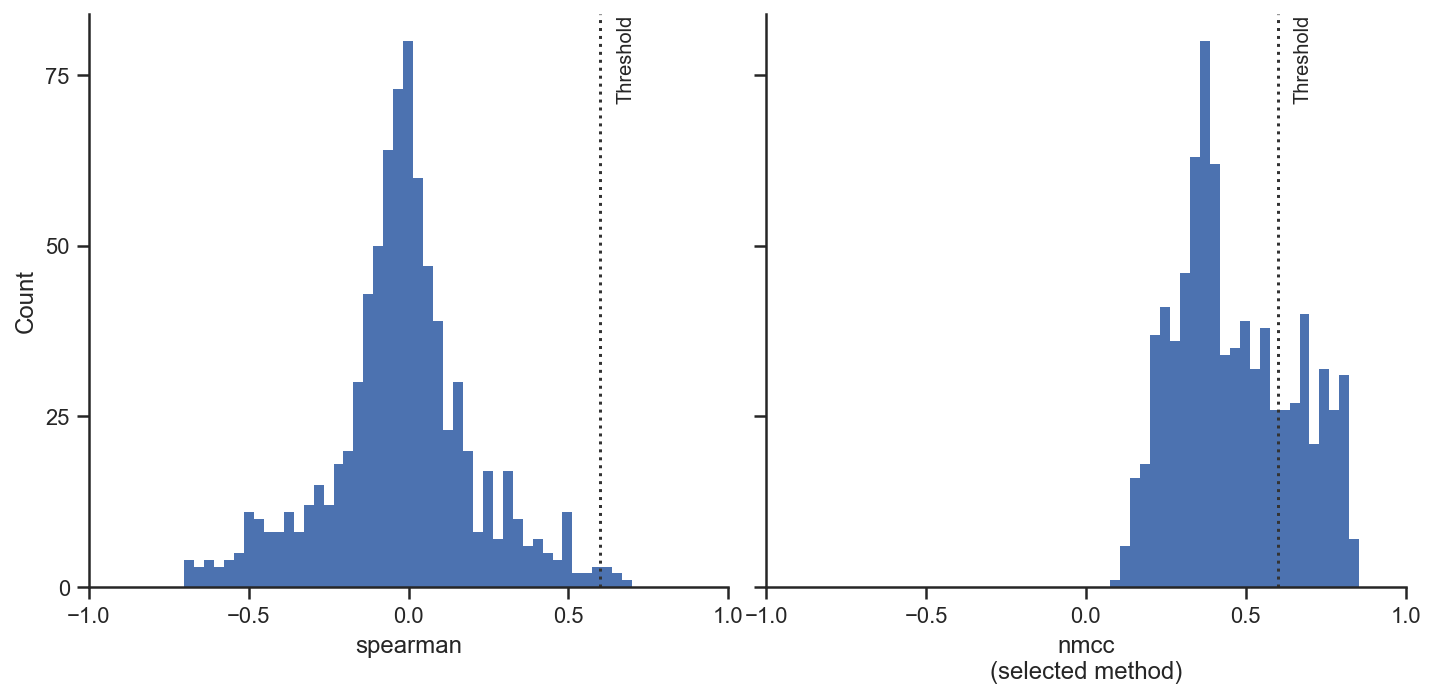

In [8]:
g = sns.displot(
    scores_agg.melt(value_vars = ["spearman", "nmcc"]),
    x="value",
    col="variable",
    kind="hist",
    bins=50,
    fill=True,
    linewidth=0,
    alpha=1
)

g.set_titles("")

for ax, title in zip(g.axes.flatten(), g.col_names):
    ax.axvline(x=selection_threshold, c="0.2", linestyle=":")
    ax.text(
        s="Threshold", 
        x=selection_threshold+0.05, 
        y=plt.ylim()[1], 
        fontsize=10, 
        va="top",
        rotation=90
    )
    if title == selection_method:
        ax.set_xlabel(title + "\n(selected method)")
    else:
        ax.set_xlabel(title)

plt.xlim(-1, 1)
ax.locator_params(nbins=4) 

plt.show()


Ions for which the selected score is above the selection threshold will be included in your custom database.

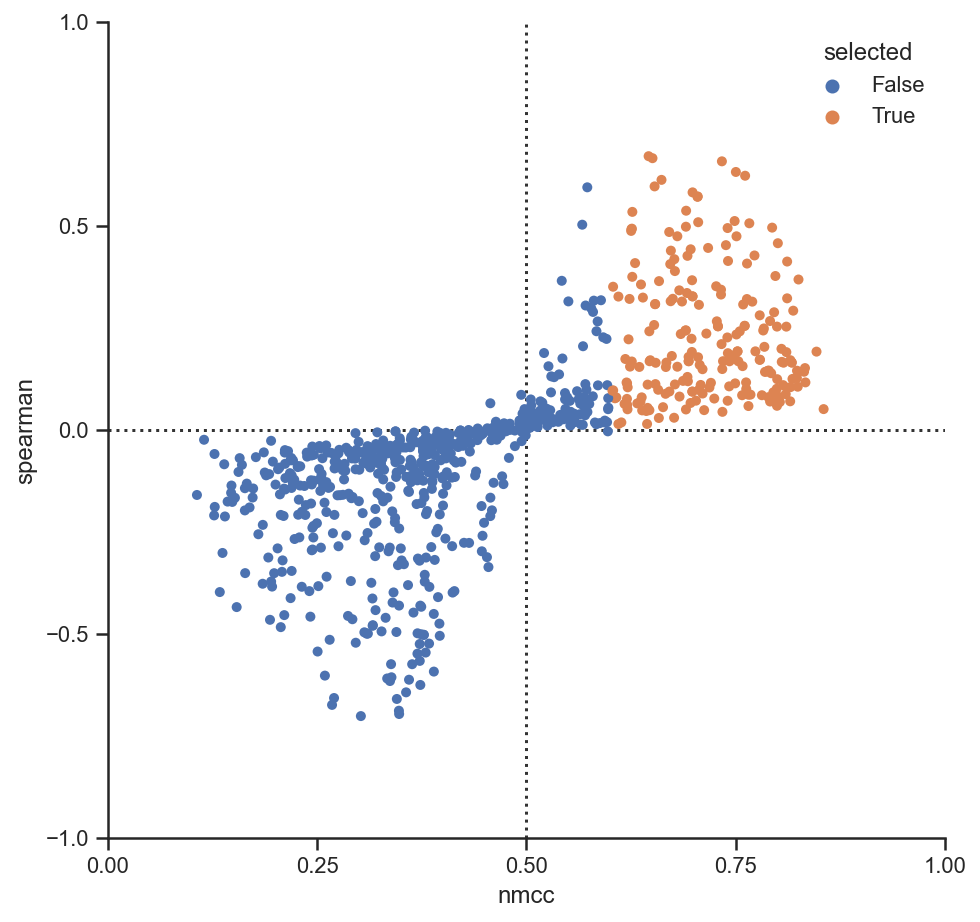

In [9]:
sns.scatterplot(
    data=scores_agg,
    x="nmcc",
    y="spearman",
    linewidth=0,
    hue="selected",
    s=25
)

plt.axhline(y=0, c=".2", linestyle=":", zorder=0)
plt.axvline(x=0.5, c="0.2", linestyle=":", zorder=0)

plt.xlim([0, 1])
plt.ylim([-1, 1])

plt.locator_params(nbins=4)
sns.despine()
plt.show()

Note that the two different scores are are not proportional, therefore depending on the chosen method you may select different ions.   

<div class="alert alert-info">

- Spearman correlation will favor ions that are intracellular but also present in the majority of cells.  
- NMCC will favor all ions that are intracellular, but not necessarily present in all cells.

</div>

In [10]:
selected_ions = scores_agg[
    scores_agg["selected"]
].index

selected_metabolites = np.unique([re.match(r"^(.+?)[\+-]", x).group(1) for x in selected_ions])

print(f"Selected {selected_metabolites.size} metabolites.")

Selected 171 metabolites.


### Create & upload new database

An easy way to now restrict your single-cell analysis to intrallular ions is to exclude all ions that are not part of `selected_metabolites`. An even better way however is to use this list of ions and turn it into a custom database for METASPACE and reannotate your datasets, as using a custom database will also combat the issue of missing values due to METASPACE's FDR threshold.

To create a custom database, you're going to need a name and a version number:

In [11]:
db_name = "Gastrosome_FeedingW3_intra_ions"
db_version = "v1"
# db_name = "Gastrosome_DrugW8_intra_ions"
# db_version = "v2"

db_filename = f"AB_{db_name}_{db_version}.tsv" # XY = ideally your initials for easier handling on METASPACE

import os
out_file = os.path.join("/Users/alberto-mac/EMBL_ATeam/projects/gastrosome", db_filename)

In [12]:
df_df = pd.DataFrame(
    {
        "name": selected_metabolites,
        "formula": selected_metabolites
    },
    index = pd.RangeIndex(start=1, stop=selected_metabolites.size + 1, name="id")
)
df_df.to_csv(
    db_filename, sep="\t", index=True
)
df_df.to_csv(
    out_file, sep="\t", index=True
)

Once we have the database file, we can upload it to METASPACE:

In [13]:
sm = SMInstance()

In [14]:
# This will prompt you to enter your API key if needed and it will save it to a config file.
# Note that API keys should be kept secret like passwords.
# sm.save_login()

In [16]:
upload_result = sm.create_database(
    local_path=db_filename,
    name=db_name,
    version=db_version,
    is_public=False,
)

upload_result

Uploading part   1/  1 of AB_Gastrosome_FeedingW3_intra_ions_v1.tsv file...


{'id': 471}

This chunk of code will create the database and return a number corresponding to your database's ID. Write it down and continue with the [reannotation notebook](bulk_reannotation.ipynb) to reannotate your datasets against the new database.